In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cactas as C
import os
import mahotas as mh
import nibabel as nib
import nrrd
import skimage.morphology
import cv2
from skimage.filters import threshold_otsu

In [3]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
gpu_available

2024-05-14 14:10:29.705968: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-05-14 14:10:31.659218: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 14:10:31.660095: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-05-14 14:10:32.205754: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-14 14:10:32.208251: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:0f:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 3

True

In [4]:
DATAPATH='/raid/mpsych/CACTAS/DATA/ESUS'
CAPATH='/raid/mpsych/CACTAS/DATA/CA24'

In [5]:
images, labels = C.Helper.load_data(DATAPATH)

In [6]:
masks = C.Helper.load_seg_data(CAPATH)

In [7]:
X_train, y_train, m_train, X_test, y_test, m_test = C.Helper.split_patients_masks(images, labels, masks)

In [8]:
X_train, y_train, m_train, X_test, y_test, m_test = C.Helper.normalization2(DATAPATH, CAPATH, X_train, y_train, m_train, X_test, y_test, m_test)

In [9]:
slice_to_patient_mapping, last_key = C.Helper.map_and_key(y_train)

In [10]:
X_train, y_train, X_test, y_test = C.Helper.extract_slices(X_train, y_train, X_test, y_test)

(13393, 512, 512, 1) (13393, 512, 512, 1) (3373, 512, 512, 1) (3373, 512, 512, 1)


In [11]:
m_train, m_test = C.Helper.extract_masks_slices(m_train, m_test)

(13393, 512, 512, 1) (3373, 512, 512, 1)


In [12]:
X_train, y_train, m_train = C.Helper.filter_slices(X_train, y_train, m_train)

(570, 512, 512, 1) (570, 512, 512, 1) (570, 512, 512, 1)


In [13]:
X_train.dtype, y_train.dtype, X_test.dtype, y_test.dtype

(dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'))

In [14]:
m_train.dtype

dtype('float64')

In [15]:
train_masks=[]
for i in range(len(m_train)):
    binary = (m_train[i] > 0).astype(np.uint8)
    train_masks.append(binary)

In [16]:
train_images=[]
for i in range(len(X_train)):
    train_image = X_train[i] * train_masks[i]
    train_images.append(train_image)
train_images_array = np.array(train_images)

In [17]:
#train_images_array = train_images_array.astype(np.float32)

In [18]:
train_images_array = train_images_array.reshape(train_images_array.shape[0], train_images_array.shape[1],train_images_array.shape[2], 1)

In [19]:
# for i in range(10, 20):
#     plt.imshow(train_images[i])
#     plt.show()

In [20]:
# for i in range(10, 20):
#     plt.imshow(train_images[i])
#     plt.imshow(y_train[i], cmap='gray', alpha=0.5)
#     plt.show()

In [21]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# axes[0].imshow(X_train[10], vmin=0, vmax=1)
# axes[0].set_title('Original Image')
# axes[1].imshow(train_masks[10])
# axes[1].set_title('Mask')
# axes[2].imshow(train_images[10])
# axes[2].set_title('Processed Image')
# plt.show()

In [22]:
test_masks=[]
for i in range(len(m_test)):
    binary = (m_test[i] > 0).astype(np.uint8)
    test_masks.append(binary)

In [23]:
test_images=[]
for i in range(len(X_test)):
    test_image = X_test[i] * test_masks[i]
    test_images.append(test_image)
test_images_array = np.array(test_images)

In [24]:
#test_images_array = test_images_array.astype(np.float32)

In [25]:
test_images_array = test_images_array.reshape(test_images_array.shape[0], test_images_array.shape[1],test_images_array.shape[2], 1)

In [26]:
X_train_set = train_images_array[:last_key]
y_train_set = y_train[:last_key]
X_val = train_images_array[last_key:]
y_val = y_train[last_key:]

In [27]:
#y_train_set = y_train_set.astype(np.float32)

In [28]:
#y_val = y_val.astype(np.float32)

In [29]:
X_train_set.dtype, y_train_set.dtype

(dtype('float64'), dtype('float64'))

In [30]:
X_val.dtype, y_val.dtype

(dtype('float64'), dtype('float64'))

In [31]:
test_images_array.dtype, y_test.dtype

(dtype('float64'), dtype('float64'))

In [32]:
X_val.shape, y_val.shape

((100, 512, 512, 1), (100, 512, 512, 1))

In [33]:
model = C.Helper.create_unet(X_train_set[0].shape)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


2024-05-14 14:13:42.531090: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-14 14:13:42.535026: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:0f:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-14 14:13:42.550275: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0, 1
2024-05-14 14:13:42.554383: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-14 14:13:42.558505: I tensorflow/core

In [34]:
model, history = C.Helper.train_unet(X_train_set, y_train_set, X_val, y_val, model, epochs=200)

2024-05-14 14:13:43.659692: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-05-14 14:13:43.678821: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245740000 Hz


Epoch 1/200


2024-05-14 14:13:45.271480: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-05-14 14:13:45.881866: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2024-05-14 14:13:46.529929: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2024-05-14 14:13:46.529953: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-05-14 14:13:46.530010: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-14 14:13:46.603950: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-05-14 14:13:47.305365: I tensorflow/stream_exec

29/29 [==============================] - 27s 522ms/step - loss: 0.6404 - iou: 1.6962e-04 - iou_thresholded: 0.0033 - val_loss: 2.1617 - val_iou: 3.5075e-04 - val_iou_thresholded: 7.2124e-04
Epoch 2/200
29/29 [==============================] - 17s 448ms/step - loss: 0.4798 - iou: 1.8695e-04 - iou_thresholded: 0.0131 - val_loss: 0.3931 - val_iou: 3.0153e-04 - val_iou_thresholded: 0.0883
Epoch 3/200
29/29 [==============================] - 13s 440ms/step - loss: 0.3255 - iou: 2.0461e-04 - iou_thresholded: 0.0201 - val_loss: 0.2504 - val_iou: 2.9641e-04 - val_iou_thresholded: 0.0020
Epoch 4/200
29/29 [==============================] - 13s 441ms/step - loss: 0.1998 - iou: 2.2587e-04 - iou_thresholded: 0.0100 - val_loss: 0.1505 - val_iou: 2.6353e-04 - val_iou_thresholded: 0.0020
Epoch 5/200
29/29 [==============================] - 13s 442ms/step - loss: 0.1202 - iou: 2.6977e-04 - iou_thresholded: 0.0124 - val_loss: 0.0925 - val_iou: 3.1108e-04 - val_iou_thresholded: 0.0020
Epoch 6/200
29/29 

29/29 [==============================] - 13s 442ms/step - loss: 0.0012 - iou: 0.0908 - iou_thresholded: 0.5137 - val_loss: 0.0014 - val_iou: 0.0633 - val_iou_thresholded: 0.3870
Epoch 44/200
29/29 [==============================] - 13s 439ms/step - loss: 0.0012 - iou: 0.0804 - iou_thresholded: 0.4656 - val_loss: 0.0012 - val_iou: 0.0713 - val_iou_thresholded: 0.3835
Epoch 45/200
29/29 [==============================] - 13s 440ms/step - loss: 0.0011 - iou: 0.0859 - iou_thresholded: 0.4741 - val_loss: 0.0014 - val_iou: 0.0525 - val_iou_thresholded: 0.2805
Epoch 46/200
29/29 [==============================] - 13s 439ms/step - loss: 0.0011 - iou: 0.0982 - iou_thresholded: 0.5105 - val_loss: 0.0013 - val_iou: 0.0603 - val_iou_thresholded: 0.3291
Epoch 47/200
29/29 [==============================] - 13s 441ms/step - loss: 0.0010 - iou: 0.0950 - iou_thresholded: 0.5071 - val_loss: 0.0012 - val_iou: 0.0749 - val_iou_thresholded: 0.4101
Epoch 48/200
29/29 [==============================] - 13s 

29/29 [==============================] - 13s 439ms/step - loss: 3.5873e-04 - iou: 0.3168 - iou_thresholded: 0.7049 - val_loss: 6.5166e-04 - val_iou: 0.1995 - val_iou_thresholded: 0.4542
Epoch 85/200
29/29 [==============================] - 13s 441ms/step - loss: 3.3746e-04 - iou: 0.3168 - iou_thresholded: 0.7123 - val_loss: 5.0048e-04 - val_iou: 0.2625 - val_iou_thresholded: 0.5670
Epoch 86/200
29/29 [==============================] - 13s 441ms/step - loss: 3.3344e-04 - iou: 0.3217 - iou_thresholded: 0.7111 - val_loss: 5.0730e-04 - val_iou: 0.2630 - val_iou_thresholded: 0.5722
Epoch 87/200
29/29 [==============================] - 13s 442ms/step - loss: 3.2290e-04 - iou: 0.3381 - iou_thresholded: 0.7277 - val_loss: 7.0606e-04 - val_iou: 0.1719 - val_iou_thresholded: 0.3895
Epoch 88/200
29/29 [==============================] - 13s 441ms/step - loss: 3.2202e-04 - iou: 0.3411 - iou_thresholded: 0.7279 - val_loss: 5.1151e-04 - val_iou: 0.2647 - val_iou_thresholded: 0.5540
Epoch 89/200
29/29

29/29 [==============================] - 13s 439ms/step - loss: 1.5409e-04 - iou: 0.5403 - iou_thresholded: 0.8202 - val_loss: 4.3521e-04 - val_iou: 0.3840 - val_iou_thresholded: 0.5843
Epoch 126/200
29/29 [==============================] - 13s 441ms/step - loss: 1.6933e-04 - iou: 0.5376 - iou_thresholded: 0.7936 - val_loss: 6.0037e-04 - val_iou: 0.3599 - val_iou_thresholded: 0.5242
Epoch 127/200
29/29 [==============================] - 13s 442ms/step - loss: 1.4840e-04 - iou: 0.5573 - iou_thresholded: 0.8314 - val_loss: 4.7904e-04 - val_iou: 0.3856 - val_iou_thresholded: 0.5721
Epoch 128/200
29/29 [==============================] - 13s 439ms/step - loss: 1.4073e-04 - iou: 0.5739 - iou_thresholded: 0.8418 - val_loss: 5.3562e-04 - val_iou: 0.3707 - val_iou_thresholded: 0.5568
Epoch 129/200
29/29 [==============================] - 13s 441ms/step - loss: 1.4350e-04 - iou: 0.5583 - iou_thresholded: 0.8324 - val_loss: 5.0866e-04 - val_iou: 0.3750 - val_iou_thresholded: 0.5519
Epoch 130/200


29/29 [==============================] - 13s 440ms/step - loss: 5.5279e-05 - iou: 0.7742 - iou_thresholded: 0.9515 - val_loss: 7.3286e-04 - val_iou: 0.4176 - val_iou_thresholded: 0.5209
Epoch 167/200
29/29 [==============================] - 13s 442ms/step - loss: 4.9897e-05 - iou: 0.7827 - iou_thresholded: 0.9610 - val_loss: 7.6609e-04 - val_iou: 0.4165 - val_iou_thresholded: 0.5197
Epoch 168/200
29/29 [==============================] - 13s 439ms/step - loss: 4.9876e-05 - iou: 0.7885 - iou_thresholded: 0.9596 - val_loss: 6.2520e-04 - val_iou: 0.4584 - val_iou_thresholded: 0.5646
Epoch 169/200
29/29 [==============================] - 13s 441ms/step - loss: 4.9580e-05 - iou: 0.7817 - iou_thresholded: 0.9570 - val_loss: 6.8778e-04 - val_iou: 0.4391 - val_iou_thresholded: 0.5430
Epoch 170/200
29/29 [==============================] - 13s 441ms/step - loss: 5.0467e-05 - iou: 0.7849 - iou_thresholded: 0.9559 - val_loss: 7.1085e-04 - val_iou: 0.4381 - val_iou_thresholded: 0.5376
Epoch 171/200


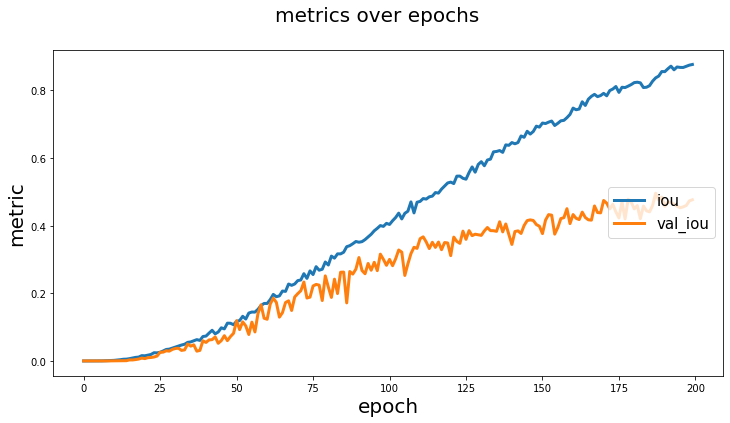

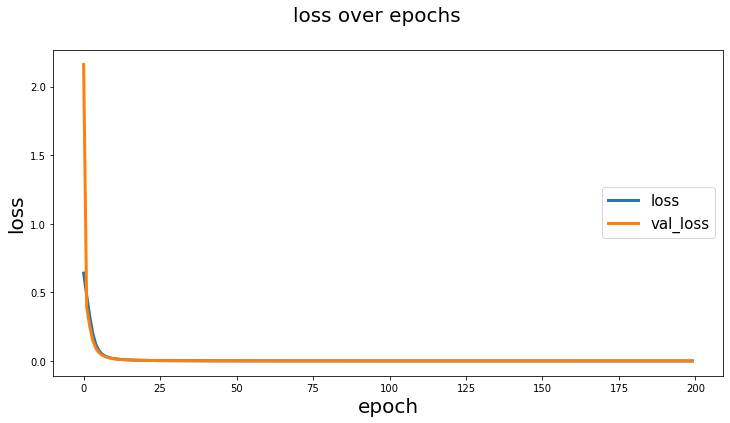

In [35]:
C.Helper.visualize_graph(history)

In [36]:
y_pred = C.Helper.prediction(test_images_array, model)

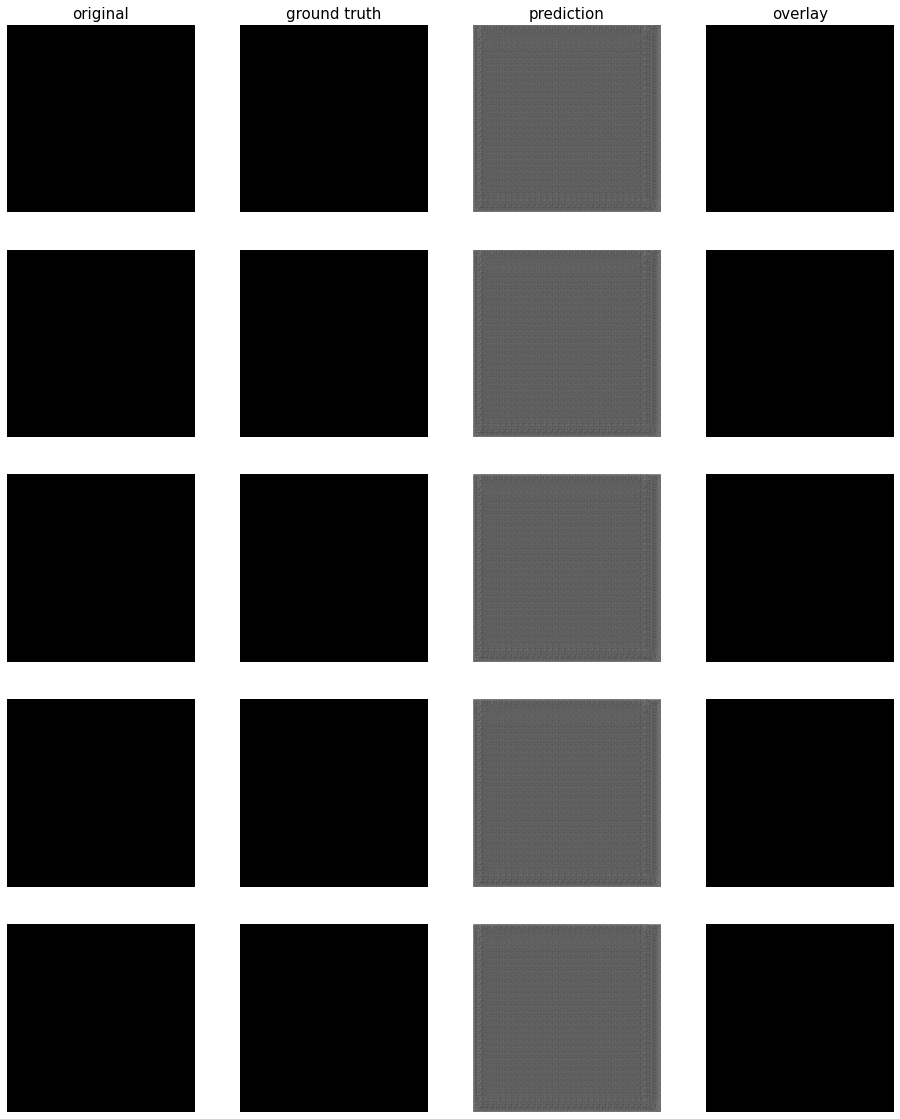

In [37]:
C.Helper.visualize_result(test_images_array, y_test, y_pred)

In [ ]:
C.Helper.evaluate(test_images_array, y_test, model)

 92/106 [=========================>....] - ETA: 3s - loss: 2.0828e-04 - iou: 0.0427 - iou_thresholded: 0.5566